# Exploratory Data Analysis

In [23]:
import sys
sys.path.insert(0, 'dontpatronizeme/semeval-2022')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dont_patronize_me import DontPatronizeMe

sns.set_theme(style='whitegrid')
%matplotlib inline

## Load data

In [24]:
DATA_DIR = 'dontpatronizeme/semeval-2022'
TEST_PATH = 'dontpatronizeme/semeval-2022/TEST/task4_test.tsv'

dpm = DontPatronizeMe(DATA_DIR, TEST_PATH)
dpm.load_task1()

df = dpm.train_task1_df.copy()
df['orig_label'] = df['orig_label'].astype(int)
df['text_len'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (10466, 9)


,par_id,art_id,keyword,country,text,label,orig_label,text_len,word_count
0,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,162,30
1,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0,277,53
2,6,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0,361,75
3,7,@@7562079,refugee,za,The European Union is making an historic mista...,0,0,301,50
4,8,@@23663488,hopeless,nz,""""""" They 're either hopeless for being beaten ...",0,0,168,39


## Train / Dev split
Use the official practice split par_ids.

In [25]:
train_ids = pd.read_csv('dontpatronizeme/semeval-2022/practice splits/train_semeval_parids-labels.csv')
dev_ids = pd.read_csv('dontpatronizeme/semeval-2022/practice splits/dev_semeval_parids-labels.csv')

df['par_id'] = df['par_id'].astype(int)
train_ids['par_id'] = train_ids['par_id'].astype(int)
dev_ids['par_id'] = dev_ids['par_id'].astype(int)

df_train = df[df['par_id'].isin(train_ids['par_id'])].copy()
df_dev = df[df['par_id'].isin(dev_ids['par_id'])].copy()

print(f'Train: {len(df_train)} | Dev: {len(df_dev)} | Total mapped: {len(df_train)+len(df_dev)} / {len(df)}')

Train: 8372 | Dev: 2094 | Total mapped: 10466 / 10466


## EDA Technique 1: Class Imbalance & Sequence Length Profiling

### Visual / Tabular Evidence

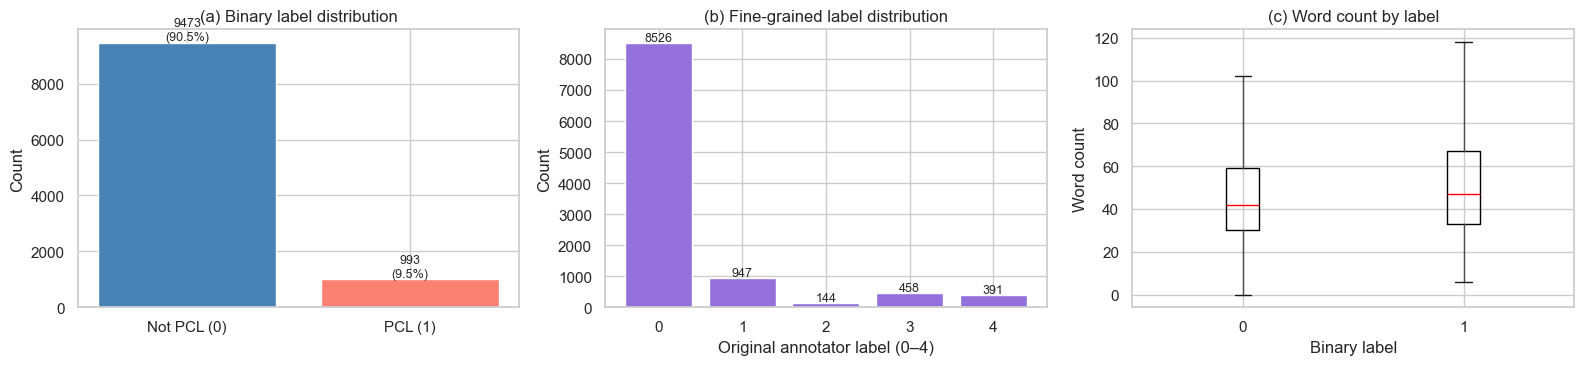


── Summary statistics (word count) by label ──
            N  Mean   Std  Min  Median    Max
label                                        
0      9473.0  47.9  28.6  0.0    42.0  909.0
1       993.0  53.6  32.8  6.0    47.0  512.0

Overall positive rate: 0.0949 (993/10466)
Imbalance ratio (neg:pos): 9.5:1


In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# (a) Binary label distribution
counts = df['label'].value_counts().sort_index()
axes[0].bar(counts.index, counts.values, color=['steelblue', 'salmon'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not PCL (0)', 'PCL (1)'])
axes[0].set_ylabel('Count')
axes[0].set_title('(a) Binary label distribution')
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 100, f'{v}\n({v/len(df)*100:.1f}%)', ha='center', fontsize=9)

# (b) Fine-grained label distribution (0–4)
orig_counts = df['orig_label'].value_counts().sort_index()
axes[1].bar(orig_counts.index, orig_counts.values, color='mediumpurple')
axes[1].set_xlabel('Original annotator label (0–4)')
axes[1].set_ylabel('Count')
axes[1].set_title('(b) Fine-grained label distribution')
for i, v in zip(orig_counts.index, orig_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontsize=9)

# (c) Word count box plot by label — crop y-axis to focus on the boxes
df.boxplot(column='word_count', by='label', ax=axes[2], showfliers=False,
           boxprops=dict(color='black'), medianprops=dict(color='red'))
# Set y-limit based on the whisker range (Q3 + 1.5*IQR) with a small margin
q1 = df.groupby('label')['word_count'].quantile(0.25).min()
q3 = df.groupby('label')['word_count'].quantile(0.75).max()
iqr = q3 - q1
axes[2].set_xlabel('Binary label')
axes[2].set_ylabel('Word count')
axes[2].set_title('(c) Word count by label')
fig.suptitle('')  # remove pandas auto-title

plt.tight_layout()
plt.savefig('figures/eda1_class_and_length.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics table
print('\n── Summary statistics (word count) by label ──')
summary = df.groupby('label')['word_count'].describe()[['count','mean','std','min','50%','max']]
summary.columns = ['N', 'Mean', 'Std', 'Min', 'Median', 'Max']
print(summary.round(1).to_string())

print(f'\nOverall positive rate: {df["label"].mean():.4f} ({counts[1]}/{len(df)})')
print(f'Imbalance ratio (neg:pos): {counts[0]/counts[1]:.1f}:1')

### Analysis

The dataset exhibits **severe class imbalance**: only ~9.5% of paragraphs are labelled as PCL (positive), yielding a negative-to-positive ratio of roughly 9.5:1. The fine-grained label distribution (panel b) reveals that the majority of positives come from label 2 (borderline agreement between annotators), with very few paragraphs receiving the strongest label of 4. This suggests a long tail of "soft" positives where annotators only partially agreed on the presence of PCL.

Panel (c) shows that **PCL-positive paragraphs tend to be longer** than negative ones. The median word count for positive examples is notably higher, and the interquartile range is wider. This makes intuitive sense: patronising language often involves elaboration, storytelling, or emotive description, all of which produce longer text.

### Impact Statement

1. **Class-weighted training.** A naive classifier predicting "Not PCL" for every input would achieve ~90.5% accuracy, so accuracy is a misleading metric. We will use **F1 for the positive class** as the primary metric (matching the shared task) and address the imbalance during training via class-weighted cross-entropy loss or focal loss.
2. **Tokeniser `max_length`.** The word-count distribution informs our choice of maximum sequence length for the transformer tokeniser. Since PCL paragraphs skew longer and we do not want to truncate informative content, we should set `max_length` generously (e.g. 256 subword tokens) and verify that truncation affects only a negligible fraction of positive examples.

## EDA Technique 2: Discriminative N-gram Analysis

### Visual / Tabular Evidence

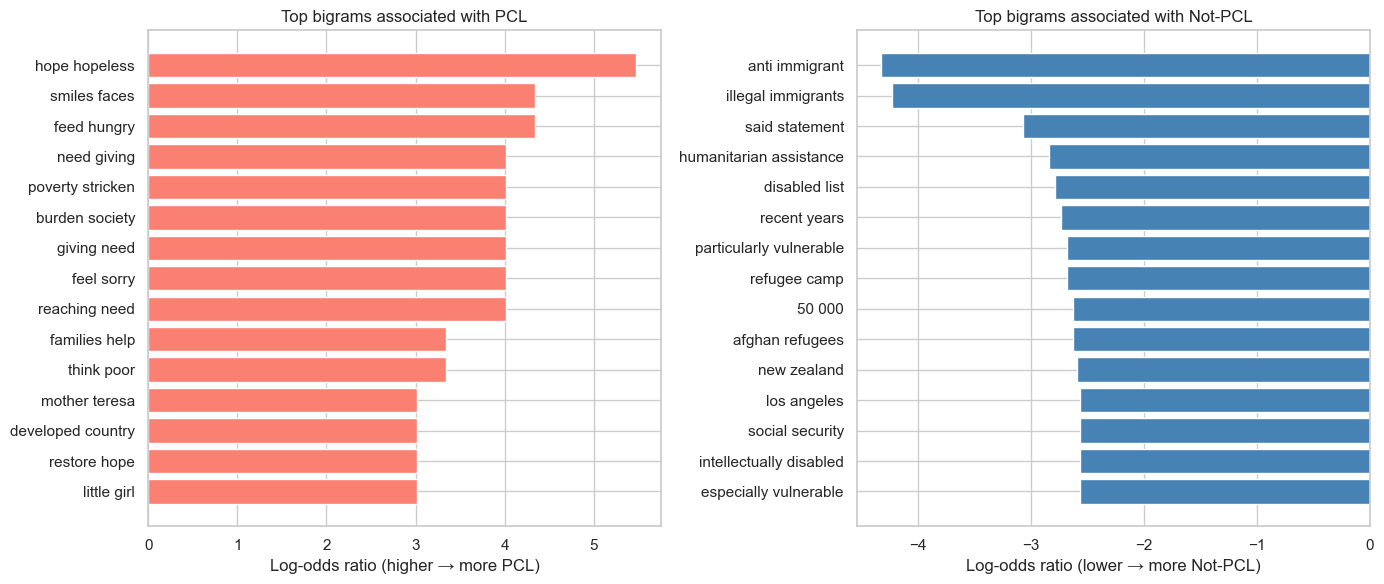


── Top 15 PCL-associated bigrams ──
  hope hopeless                  log-odds = +5.48
  smiles faces                   log-odds = +4.34
  feed hungry                    log-odds = +4.34
  need giving                    log-odds = +4.02
  poverty stricken               log-odds = +4.02
  burden society                 log-odds = +4.02
  giving need                    log-odds = +4.02
  feel sorry                     log-odds = +4.02
  reaching need                  log-odds = +4.02
  families help                  log-odds = +3.34
  think poor                     log-odds = +3.34
  mother teresa                  log-odds = +3.02
  developed country              log-odds = +3.02
  restore hope                   log-odds = +3.02
  little girl                    log-odds = +3.02

── Top 15 Not-PCL-associated bigrams ──
  anti immigrant                 log-odds = -4.32
  illegal immigrants             log-odds = -4.23
  said statement                 log-odds = -3.07
  humanitarian assista

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(texts, n=2, top_k=20):
    """Return the top_k most frequent n-grams."""
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english', max_features=10000)
    X = vec.fit_transform(texts)
    freqs = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    idx = freqs.argsort()[::-1][:top_k]
    return list(zip(vocab[idx], freqs[idx]))

def log_odds_ratio(texts_pos, texts_neg, n=2, top_k=15):
    """
    Compute the log-odds ratio of n-grams between positive and negative classes.
    A high positive value means the n-gram is more associated with PCL.
    """
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english', min_df=3)
    all_texts = list(texts_pos) + list(texts_neg)
    X = vec.fit_transform(all_texts)
    n_pos = len(texts_pos)

    counts_pos = X[:n_pos].sum(axis=0).A1 + 1  # Laplace smoothing
    counts_neg = X[n_pos:].sum(axis=0).A1 + 1
    total_pos = counts_pos.sum()
    total_neg = counts_neg.sum()

    lor = np.log2((counts_pos / total_pos) / (counts_neg / total_neg))
    vocab = vec.get_feature_names_out()

    top_pcl = lor.argsort()[::-1][:top_k]
    top_neg = lor.argsort()[:top_k]
    return vocab, lor, top_pcl, top_neg

pcl_texts = df[df['label'] == 1]['text']
neg_texts = df[df['label'] == 0]['text']

vocab, lor, top_pcl_idx, top_neg_idx = log_odds_ratio(pcl_texts, neg_texts, n=2, top_k=15)

# ── Plot ──
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top bigrams skewed towards PCL
pcl_ngrams = vocab[top_pcl_idx]
pcl_scores = lor[top_pcl_idx]
axes[0].barh(range(len(pcl_ngrams)), pcl_scores, color='salmon')
axes[0].set_yticks(range(len(pcl_ngrams)))
axes[0].set_yticklabels(pcl_ngrams)
axes[0].invert_yaxis()
axes[0].set_xlabel('Log-odds ratio (higher → more PCL)')
axes[0].set_title('Top bigrams associated with PCL')

# Top bigrams skewed towards Not-PCL
neg_ngrams = vocab[top_neg_idx]
neg_scores = lor[top_neg_idx]
axes[1].barh(range(len(neg_ngrams)), neg_scores, color='steelblue')
axes[1].set_yticks(range(len(neg_ngrams)))
axes[1].set_yticklabels(neg_ngrams)
axes[1].invert_yaxis()
axes[1].set_xlabel('Log-odds ratio (lower → more Not-PCL)')
axes[1].set_title('Top bigrams associated with Not-PCL')

plt.tight_layout()
plt.savefig('figures/eda2_ngram_log_odds.png', dpi=150, bbox_inches='tight')
plt.show()

# Print as a table
print('\n── Top 15 PCL-associated bigrams ──')
for ng, s in zip(pcl_ngrams, pcl_scores):
    print(f'  {ng:<30s} log-odds = {s:+.2f}')
print('\n── Top 15 Not-PCL-associated bigrams ──')
for ng, s in zip(neg_ngrams, neg_scores):
    print(f'  {ng:<30s} log-odds = {s:+.2f}')

### Analysis

We compute the **log-odds ratio** of bigram frequencies between the PCL-positive and PCL-negative classes. This measures how much more (or less) likely each bigram is to appear in patronising text versus non-patronising text, after Laplace smoothing.

The PCL-associated bigrams fall into clear **patronising archetypes** from the paper's taxonomy:
- **Saviour framing:** *"feed hungry"*, *"families help"*, *"need giving"*, *"giving need"*, *"reaching need"*, *"restore hope"* — language that positions the speaker as a rescuer.
- **Compassion / pity:** *"feel sorry"*, *"smiles faces"*, *"hope hopeless"* — emotive, flowery descriptions that sentimentalise hardship.
- **Power asymmetry:** *"burden society"*, *"poverty stricken"*, *"think poor"*, *"little girl"* — language that reduces people to their vulnerability.
- **Shallow solutions / clichés:** *"mother teresa"*, *"developed country"* — invoking well-known figures or broad generalisations as substitutes for substantive discussion.

The Not-PCL bigrams are strikingly different in character: they are **factual, institutional, or geographic** — *"said statement"*, *"humanitarian assistance"*, *"refugee camp"*, *"social security"*, *"new zealand"*, *"los angeles"*, *"50 000"*. Several relate to neutral reporting (*"anti immigrant"*, *"illegal immigrants"*, *"afghan refugees"*) or clinical descriptions (*"disabled list"*, *"intellectually disabled"*). These bigrams describe vulnerable groups without the emotive or condescending framing that characterises PCL.

This confirms the PCL paper's finding that certain categories (e.g. *Compassion*, *Unbalanced power relations*) rely on identifiable lexical cues, while also showing that the boundary between PCL and neutral text is **contextual** — words like *"need"*, *"hope"*, and *"poor"* appear in both classes, and their patronising interpretation depends on surrounding framing.

### Impact Statement

1. **Contextualised model required.** Individual words like *"need"*, *"hope"*, and *"poor"* appear in both classes; it is the surrounding framing that makes them patronising. A bag-of-words or averaged-embedding approach would conflate these usages, confirming that a **contextualised language model** (e.g. RoBERTa) is necessary to capture the distinction.
2. **Minimal text preprocessing.** The discriminative bigrams consist of common English words in specific combinations. Aggressive preprocessing (e.g. stop-word removal or lemmatisation) would destroy phrases like *"feel sorry"* or *"need giving"* that carry the patronising signal. We should feed **raw text** into the transformer tokeniser with no cleaning beyond what the tokeniser handles natively.